In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re
from scipy.stats import pearsonr, spearmanr
import nltk
from unidecode import unidecode
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import chi2_contingency
from matplotlib.colors import LogNorm

In [5]:
customers_df = pd.read_csv(r"/content/olist_customers_dataset.csv")

In [6]:
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
customers_df.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               5 non-null      object
 1   customer_unique_id        5 non-null      object
 2   customer_zip_code_prefix  5 non-null      int64 
 3   customer_city             5 non-null      object
 4   customer_state            5 non-null      object
dtypes: int64(1), object(4)
memory usage: 332.0+ bytes


In [8]:
geoloc_df = pd.read_csv("/content/olist_geolocation_dataset.csv")

In [9]:
geoloc_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [10]:
geoloc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [11]:
payments_df = pd.read_csv("/content/olist_order_payments_dataset.csv")

In [12]:
payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [13]:
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [14]:
orderitems_df = pd.read_csv("/content/olist_order_items_dataset.csv")

In [15]:
orderitems_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
orderitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [17]:
reviews_df = pd.read_csv("/content/olist_order_reviews_dataset.csv")

In [18]:
reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [19]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [20]:
orders_df = pd.read_csv("/content/olist_orders_dataset.csv")

In [21]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [22]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [23]:
products_df = pd.read_csv("/content/olist_products_dataset.csv")

In [24]:
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [25]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [26]:
sellers_df = pd.read_csv("/content/olist_sellers_dataset.csv")

In [27]:
sellers_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [28]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [29]:
productcat_df = pd.read_csv("/content/product_category_name_translation.csv")

In [30]:
productcat_df.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [31]:
productcat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


### Review anomalies

In [32]:
# Data Prep
# Basic clean & lowercase
reviews_df['review_comment_message'] = reviews_df['review_comment_message'].fillna("").astype(str).str.lower()
reviews_df['review_comment_title'] = reviews_df['review_comment_title'].fillna("").astype(str).str.lower()

In [33]:
reviews_df.isna().sum()

,0
review_id,0
order_id,0
review_score,0
review_comment_title,0
review_comment_message,0
review_creation_date,0
review_answer_timestamp,0


#### BERT Sentiment Analysis

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

50th percentile: 2 tokens
75th percentile: 13 tokens
90th percentile: 27 tokens
95th percentile: 40 tokens
99th percentile: 54 tokens


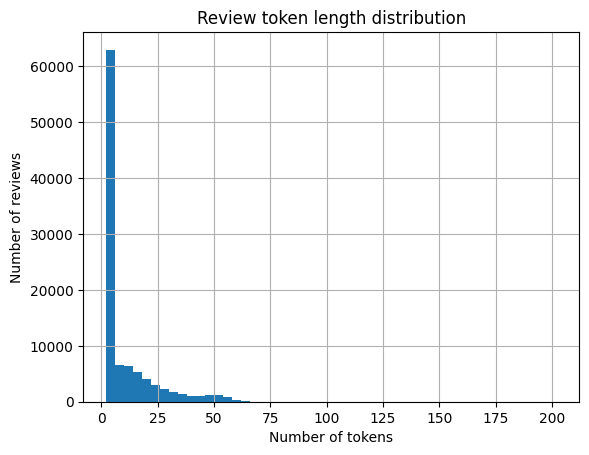

In [34]:
# Instantiating the tokenizer
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Compute token lengths for all reviews
lengths = reviews_df['review_comment_message'].apply(
    lambda txt: len(tokenizer.encode(txt, truncation=False))
)

# Key percentiles
for p in [50, 75, 90, 95, 99]:
    print(f"{p}th percentile: {int(np.percentile(lengths, p))} tokens")

# Plot a histogram

lengths.hist(bins=50)
plt.title("Review token length distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Number of reviews")
plt.show()


In [35]:
# Load the multilingual BERT sentiment model
MODEL_NAME = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Device config
import torch
device = 0 if torch.cuda.is_available() else -1

# Define optimized pipeline
bert_pipeline = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=False,
    device=device,
    truncation=True,
    padding='max_length',
    max_length=64,
    batch_size=64
)


model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [36]:
# Run predictions in batch
texts = reviews_df["review_comment_message"].tolist()
predictions = bert_pipeline(texts)

# Extract predicted sentiment scores (as int 1–5)
reviews_df["predicted_sentiment"] = [int(pred["label"][0]) for pred in predictions]

# Convert review_score to integer
reviews_df["review_score"] = reviews_df["review_score"].astype(int)

# Calculate mismatch
reviews_df["sentiment_mismatch"] = abs(reviews_df["review_score"] - reviews_df["predicted_sentiment"])

# Flag anomalies (mismatch ≥ 2)
reviews_df["anomaly"] = reviews_df["sentiment_mismatch"] >= 2

# Show example anomalies
anomalies = reviews_df[reviews_df["anomaly"] == True][[
    "review_comment_message", "review_score", "predicted_sentiment", "sentiment_mismatch"
]]

# View anomalies
anomalies.head()

,review_comment_message,review_score,predicted_sentiment,sentiment_mismatch
3,recebi bem antes do prazo estipulado.,5,3,2
5,,1,4,3
24,obrigado pela atençao amim dispensada,5,1,4
40,,2,4,2
41,,1,4,3


In [37]:
# Total number of anomalies
num_anomalies = reviews_df["anomaly"].sum()
print("Number of anomalous reviews:", num_anomalies)


Number of anomalous reviews: 11642


In [38]:
# Number of exact matches
num_matches = (reviews_df["review_score"] == reviews_df["predicted_sentiment"]).sum()

# Total valid reviews checked
total_reviews = len(reviews_df)

# Accuracy
accuracy = num_matches / total_reviews
print(f"Accuracy between review_score and predicted sentiment: {accuracy:.2%}")


Accuracy between review_score and predicted sentiment: 37.29%


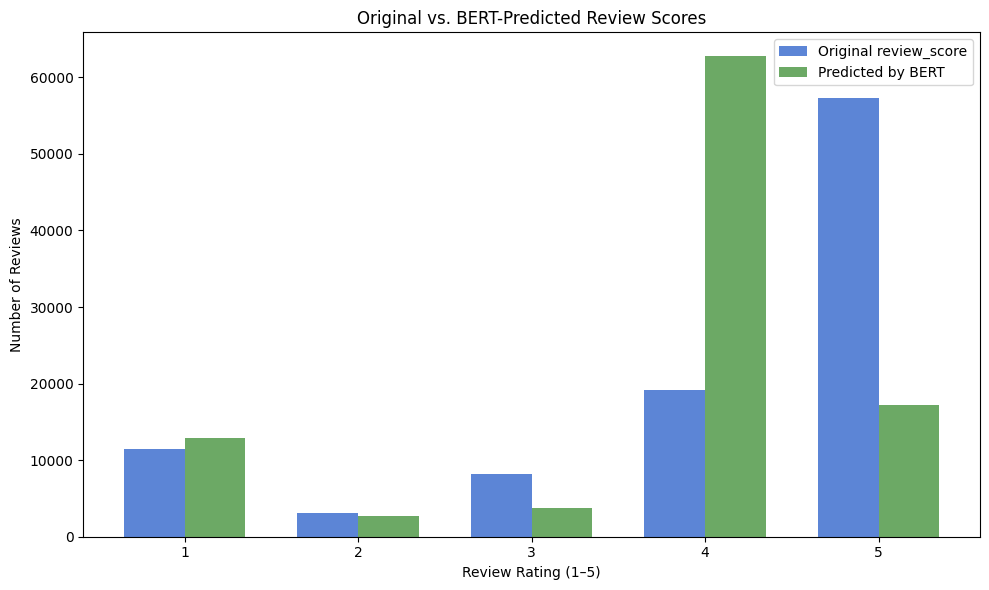

In [39]:

# Count of original review scores (ground truth)
actual_counts = reviews_df["review_score"].value_counts().sort_index()

# Count of predicted sentiments (by BERT)
predicted_counts = reviews_df["predicted_sentiment"].value_counts().sort_index()

# Both have same index
index = sorted(set(actual_counts.index).union(set(predicted_counts.index)))
actual = [actual_counts.get(i, 0) for i in index]
predicted = [predicted_counts.get(i, 0) for i in index]

# Plot grouped bar chart
x = np.arange(len(index))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, actual, width, label="Original review_score", color='#5c85d6' )
plt.bar(x + width/2, predicted, width, label="Predicted by BERT", color='#6ca965')

plt.xlabel("Review Rating (1–5)")
plt.ylabel("Number of Reviews")
plt.title("Original vs. BERT-Predicted Review Scores")
plt.xticks(x, index)
plt.legend()
plt.tight_layout()
plt.show()

#### Review length vs Score

In [40]:
# Compute lengths
reviews_df['review_length_chars'] = (
    reviews_df['review_comment_message']
    .fillna("")
    .astype(str)
    .apply(len)
)
reviews_df['review_length_tokens'] = (
    reviews_df['review_comment_message']
    .fillna("")
    .astype(str)
    .apply(lambda x: len(x.split()))
)

# Summary stats by score
length_summary = reviews_df.groupby('review_score').agg(
    count=('review_length_chars','count'),
    mean_chars=('review_length_chars','mean'),
    median_chars=('review_length_chars','median'),
    mean_tokens=('review_length_tokens','mean'),
    median_tokens=('review_length_tokens','median')
).reset_index()

print("Review Length Summary by Star Rating:\n")
print(length_summary.to_string(index=False))

Review Length Summary by Star Rating:

 review_score  count  mean_chars  median_chars  mean_tokens  median_tokens
            1  11424   76.504902          63.0    13.393557           11.0
            2   3151   65.926373          47.0    11.666455            8.0
            3   8179   36.240494           0.0     6.370461            0.0
            4  19142   19.272803           0.0     3.306185            0.0
            5  57328   18.586188           0.0     3.025031            0.0


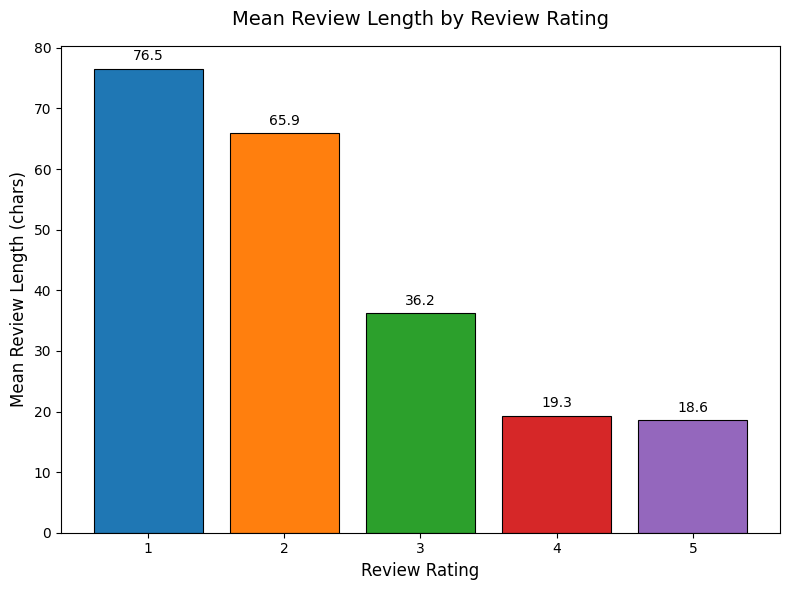

In [41]:
scores = length_summary['review_score'].astype(str)
means  = length_summary['mean_chars']
colors = plt.cm.tab10(np.arange(len(scores)))

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(scores, means,
              color=colors,
              edgecolor='black',
              linewidth=0.8)

# Labels & title
ax.set_xlabel("Review Rating", fontsize=12)
ax.set_ylabel("Mean Review Length (chars)", fontsize=12)
ax.set_title("Mean Review Length by Review Rating", fontsize=14, pad=15)


# Annotate values on each bar
for bar in bars:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}',
                xy=(bar.get_x()+bar.get_width()/2, h),
                xytext=(0, 4),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipython-input-42-1998313962.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data,


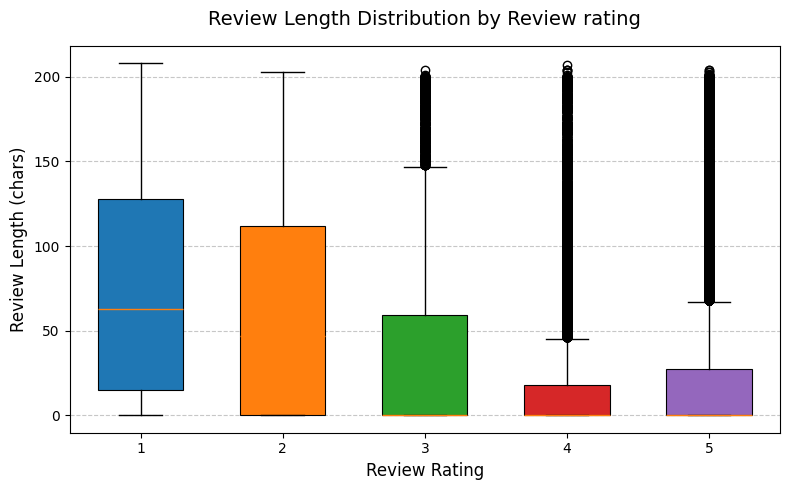

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))

data = [
    reviews_df.loc[reviews_df['review_score']==int(s), 'review_length_chars']
    for s in scores
]

box = ax.boxplot(data,
                 patch_artist=True,
                 labels=scores,
                 widths=0.6)
# Horizontal grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(0.8)

# Labels & title
ax.set_xlabel("Review Rating", fontsize=12)
ax.set_ylabel("Review Length (chars)", fontsize=12)
ax.set_title("Review Length Distribution by Review rating", fontsize=14, pad=15)

# Horizontal grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Late Orders vs Review

In [43]:
#  Merge reviews with order info
# Compute order value by summing item prices
order_value = (
    orderitems_df
    .groupby('order_id')['price']
    .sum()
    .reset_index(name='order_value')
)

# Merge reviews with order dates
df = (
    reviews_df
    .merge(
        orders_df[['order_id',
                   'order_estimated_delivery_date',
                   'order_delivered_customer_date']],
        on='order_id',
        how='left'
    )
    # Merge in the computed order_value
    .merge(order_value, on='order_id', how='left')
)

In [44]:
# Parse dates
df['order_estimated_delivery_date'] = pd.to_datetime(
    df['order_estimated_delivery_date'], errors='coerce'
)
df['order_delivered_customer_date'] = pd.to_datetime(
    df['order_delivered_customer_date'], errors='coerce'
)

# Compute raw delay in days (negative = early)
df['delay_days'] = (
    df['order_delivered_customer_date']
    - df['order_estimated_delivery_date']
).dt.days

# Impute (clip) all negative delays to zero
df['delay_days'] = df['delay_days'].clip(lower=0)

# Flag late deliveries (now anything >0)
df['is_late'] = df['delay_days'] > 0

In [45]:
# Summary stats on the clipped delays
summary_all = df['delay_days'].describe().astype(int)
print("All deliveries (negatives → 0) delay_days summary:\n", summary_all)

# Late deliveries
late_df = df[df['is_late']]
summary_late = late_df['delay_days'].describe().astype(int)
print("\nLate‐delivery only delay_days summary:\n", summary_late)

All deliveries (negatives → 0) delay_days summary:
 count    96359
mean         0
std          4
min          0
25%          0
50%          0
75%          0
max        188
Name: delay_days, dtype: int64

Late‐delivery only delay_days summary:
 count    6410
mean       10
std        14
min         1
25%         3
50%         7
75%        13
max       188
Name: delay_days, dtype: int64


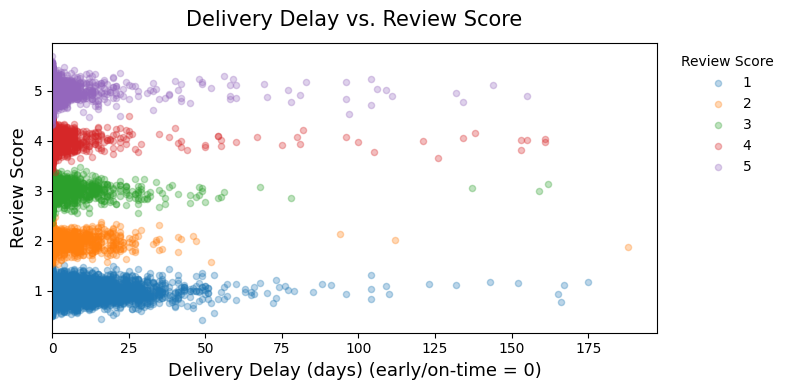

In [46]:
plot_df = df[df['review_score'].notna()]

ratings = sorted(plot_df['review_score'].unique())
palette = plt.cm.tab10(np.arange(len(ratings)))
jitter_strength = 0.15

fig, ax = plt.subplots(figsize=(8, 4))

for i, score in enumerate(ratings):
    sub = plot_df[plot_df['review_score'] == score]
    x = sub['delay_days']
    y = np.random.normal(loc=score, scale=jitter_strength, size=len(sub))
    ax.scatter(x, y, alpha=0.3, s=20, color=palette[i], label=str(score))

ax.set_xlim(left=0)
ax.set_xlabel("Delivery Delay (days) (early/on-time = 0)", fontsize=13)
ax.set_ylabel("Review Score", fontsize=13)
ax.set_title("Delivery Delay vs. Review Score", fontsize=15, pad=12)
ax.grid(False)

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Review Score", frameon=False)

plt.tight_layout()
plt.show()

In [47]:
# drop any rows where delay_days or review_score is NaN
corr_df = df[['delay_days', 'review_score']].dropna()

# Compute Pearson’s r
r_pearson, _ = pearsonr(corr_df['delay_days'], corr_df['review_score'])
print(f"Pearson’s r = {r_pearson:.3f}")

# Compute Spearman’s ρ
rho_spearman, _ = spearmanr(corr_df['delay_days'], corr_df['review_score'])
print(f"Spearman’s ρ = {rho_spearman:.3f}")


Pearson’s r = -0.263
Spearman’s ρ = -0.314


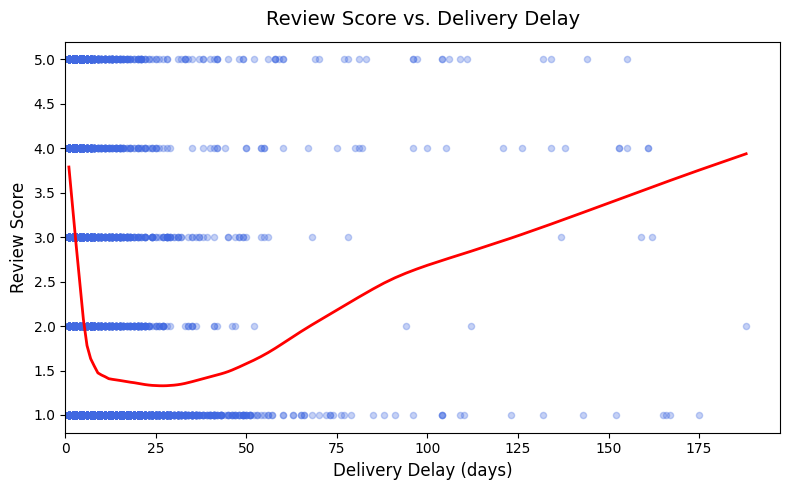

In [48]:
#  Only late deliveries, drop any NaNs
plot_df = df.loc[df['delay_days'] > 0, ['delay_days', 'review_score']].dropna()

plt.figure(figsize=(8, 5))
sns.regplot(
    x='delay_days',
    y='review_score',
    data=plot_df,
    scatter_kws={'alpha': 0.3, 's': 20, 'color': 'royalblue'},
    line_kws={'color': 'red', 'lw': 2},
    lowess=True
)

plt.xlim(left=0)
plt.xlabel("Delivery Delay (days)", fontsize=12)
plt.ylabel("Review Score", fontsize=12)
plt.title("Review Score vs. Delivery Delay", fontsize=14, pad=12)
plt.tight_layout()
plt.show()


/tmp/ipython-input-49-2993106067.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('delay_bucket')['review_score']
/tmp/ipython-input-49-2993106067.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='delay_bucket', y='mean_score', data=bucket_summary, palette='Blues_d')
/tmp/ipython-input-49-2993106067.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='delay_bucket', y='count', data=bucket_summary, palette='Greens_d')


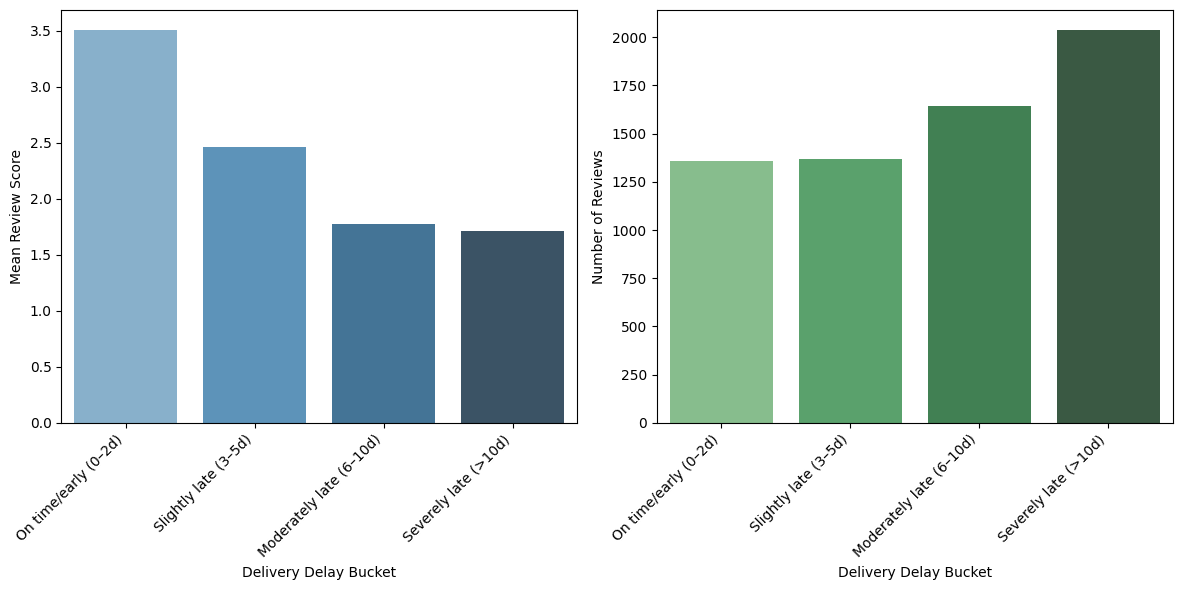

In [49]:
# delay_days is non-negative
df['delay_days'] = df['delay_days'].clip(lower=0)

# Buckets for late deliveries
bins = [0, 2, 5, 10, np.inf]
labels = [
    'On time/early (0–2d)',
    'Slightly late (3–5d)',
    'Moderately late (6–10d)',
    'Severely late (>10d)'
]
df['delay_bucket'] = pd.cut(df['delay_days'], bins=bins, labels=labels, right=True)

bucket_summary = (
    df
    .groupby('delay_bucket')['review_score']
    .agg(count='count', mean_score='mean', median_score='median')
    .reset_index()
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='delay_bucket', y='mean_score', data=bucket_summary, palette='Blues_d')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Review Score")
plt.xlabel("Delivery Delay Bucket")

plt.subplot(1, 2, 2)
sns.barplot(x='delay_bucket', y='count', data=bucket_summary, palette='Greens_d')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Reviews")
plt.xlabel("Delivery Delay Bucket")

plt.tight_layout()
plt.show()


#### Order Value and Review Score

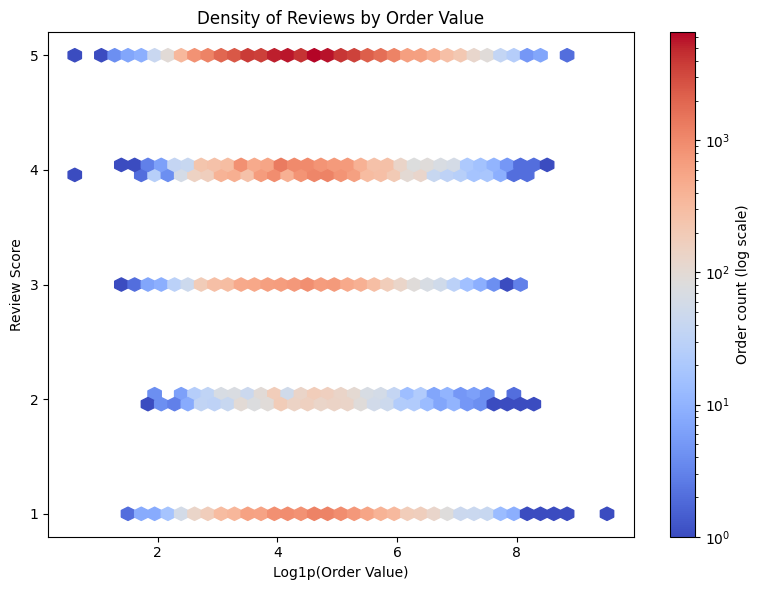

In [50]:
df['log_value'] = np.log1p(df['order_value'])
plot_df = df.dropna(subset=['log_value','review_score'])

plt.figure(figsize=(8,6))
hb = plt.hexbin(
    plot_df['log_value'],
    plot_df['review_score'],
    gridsize=40,
    cmap='coolwarm',
    norm=LogNorm(),
    mincnt=1
)
cb = plt.colorbar(hb)
cb.set_label('Order count (log scale)')

plt.xlabel("Log1p(Order Value)")
plt.ylabel("Review Score")
plt.title("Density of Reviews by Order Value")

# remove the .5 ticks
plt.yticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()


In [51]:
# data
corr_df = df[['order_value', 'review_score']].dropna()

# Pearson correlation
r, _ = pearsonr(corr_df['order_value'], corr_df['review_score'])
print(f"Pearson’s r = {r:.3f}")

# Spearman correlation
rho, _ = spearmanr(corr_df['order_value'], corr_df['review_score'])
print(f"Spearman’s ρ = {rho:.3f}")


Pearson’s r = -0.040
Spearman’s ρ = -0.033


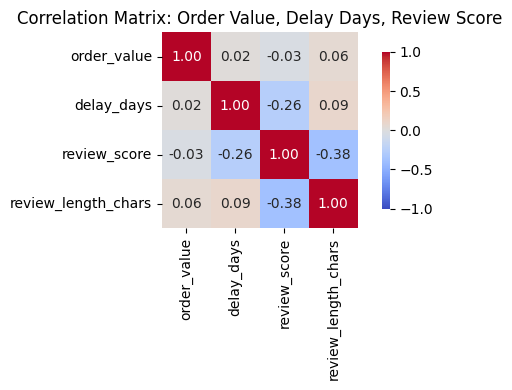

In [52]:
# Drop missing
df['review_length_chars'] = (
    df['review_comment_message']
    .fillna("")
    .astype(str)
    .apply(len)
)
corr_df = df[['order_value', 'delay_days', 'review_score', 'review_length_chars']].dropna()

# Correlation matrix
corr_matrix = corr_df.corr()

# plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Correlation Matrix: Order Value, Delay Days, Review Score")
plt.tight_layout()
plt.show()


#### Chi-Square test

In [53]:
# Bucketize delays
bins = [0, 2, 5, 10, np.inf]
labels = ['0–2d', '3–5d', '6–10d', '>10d']
df['delay_bucket'] = pd.cut(df['delay_days'], bins=bins, labels=labels, right=True)

# Contingency table
df['is_5star'] = df['review_score'] == 5
ct = pd.crosstab(df['is_5star'], df['delay_bucket'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct.values)

# Compute standardized residuals
std_resid = (ct.values - expected) / np.sqrt(expected)
resid_df = pd.DataFrame(
    std_resid.round(2),
    index=['not_5', '5'],
    columns=labels
)

resid_df

,0–2d,3–5d,6–10d,>10d
not_5,-7.93,-1.59,3.50,4.63
5,17.81,3.56,-7.86,-10.41


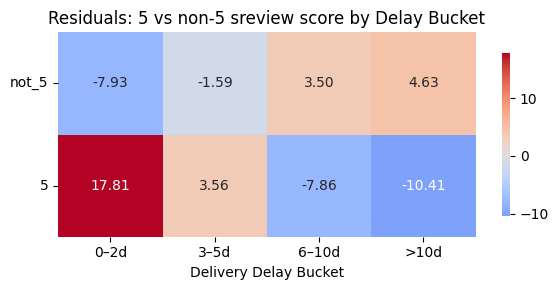

In [54]:
# Heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(
    resid_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'shrink': 0.8}
)
plt.xlabel("Delivery Delay Bucket")
plt.yticks(rotation=0)
plt.title("Residuals: 5 vs non-5 sreview score by Delay Bucket")
plt.tight_layout()
plt.show()

In [55]:
df['value_quartile'] = pd.qcut(df['order_value'], q=4)

df['is_5'] = df['review_score'] == 5
ct_val = pd.crosstab(df['is_5'], df['value_quartile'])

chi2, p, dof, expected = chi2_contingency(ct_val.values)

std_resid_val = (ct_val.values - expected) / np.sqrt(expected)
resid_val_df = pd.DataFrame(
    std_resid_val.round(2),
    index=['non5','five'],
    columns=[str(interval) for interval in ct_val.columns]
)

resid_val_df


,"(0.849, 45.9]","(45.9, 86.58]","(86.58, 149.9]","(149.9, 13440.0]"
non5,-3.08,-0.75,-0.07,3.91
five,2.61,0.63,0.06,-3.32


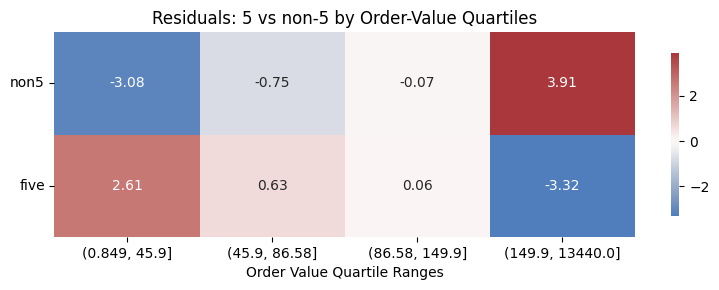

In [56]:
plt.figure(figsize=(8, 3))
sns.heatmap(
    resid_val_df,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    cbar_kws={'shrink': 0.8}
)
plt.xlabel("Order Value Quartile Ranges")
plt.yticks(rotation=0)
plt.title("Residuals: 5 vs non-5 by Order-Value Quartiles")
plt.tight_layout()
plt.show()


In [57]:
# Define length bins and labels
length_bins  = [0, 50, 100, 200, np.inf]
length_labels = ['1–50 chars', '51–100 chars', '101–200 chars', '>200 chars']

# Bucketize review length
df['length_bucket'] = pd.cut(
    df['review_length_chars'],
    bins=length_bins,
    labels=length_labels,
    right=True
)

# Flag 5‑star reviews
df['is_5star'] = df['review_score'] == 5

# Build the contingency table
ct_len = pd.crosstab(df['is_5star'], df['length_bucket'])

# Chi‑square test & standardized residuals
chi2_len, p_len, _, exp_len = chi2_contingency(ct_len.values)
std_resid_len = (ct_len.values - exp_len) / np.sqrt(exp_len)
resid_len_df = pd.DataFrame(
    std_resid_len.round(2),
    index=['not_5', '5'],
    columns=length_labels
)

resid_len_df

# #  print test stats
# print(f"χ² = {chi2_len:.2f}, p = {p_len:.4f}")
# print(resid_len_df)

,1–50 chars,51–100 chars,101–200 chars,>200 chars
not_5,-23.59,-1.22,35.22,4.30
5,23.51,1.22,-35.11,-4.28


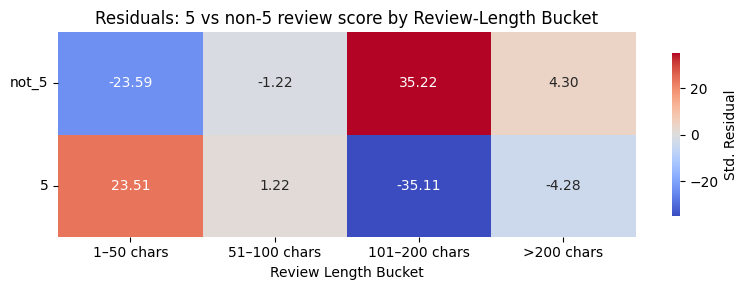

In [58]:
#  Plot heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(
    resid_len_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'shrink': 0.8, 'label': 'Std. Residual'}
)
plt.xlabel("Review Length Bucket")
plt.yticks(rotation=0)              # keep 'not_5' / '5' horizontal
plt.title("Residuals: 5 vs non‑5 review score by Review‑Length Bucket")
plt.tight_layout()
plt.show()


#### Topic Modeling

In [59]:
nltk.download('stopwords')

pt_stop = set(stopwords.words('portuguese'))
domain_stop = {'produto', 'entrega', 'entregue', 'chegou', 'compra', 'comprar', 'site', 'loja'}
all_stop = list(pt_stop.union(domain_stop))

reviews = df[['review_comment_message','review_score']].dropna().copy()
reviews['clean_msg'] = reviews['review_comment_message'].str.lower().apply(unidecode)

vectorizer = CountVectorizer(
    max_df=0.80,
    min_df=50,
    stop_words=all_stop,
    ngram_range=(1,2),
    token_pattern=r'\b[^\d\W]+\b'
)
dtm = vectorizer.fit_transform(reviews['clean_msg'])

lda = LatentDirichletAllocation(
    n_components=7,
    max_iter=15,
    learning_method='online',
    learning_decay=0.7,
    random_state=42
)
lda.fit(dtm)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, comp in enumerate(lda.components_):
    terms = [feature_names[i] for i in comp.argsort()[::-1][:10]]
    print(f"Topic {topic_idx}:", terms)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Topic 0: ['qualidade', 'tudo', 'boa', 'produtos', 'lannister', 'otima', 'recomendo', 'certo', 'otima qualidade', 'todos']
Topic 1: ['bom', 'otimo', 'previsto', 'adorei', 'nada', 'amei', 'lindo', 'achei', 'satisfeito', 'mercadoria']
Topic 2: ['recomendo', 'dia', 'pedido', 'super', 'dias', 'ok', 'super recomendo', 'contato', 'aguardando', 'problema']
Topic 3: ['prazo', 'antes', 'antes prazo', 'bem', 'excelente', 'dentro', 'dentro prazo', 'bem antes', 'perfeito', 'conforme']
Topic 4: ['ja', 'outro', 'sempre', 'correto', 'momento', 'ate', 'ter', 'pouco', 'obrigado', 'parabens']
Topic 5: ['nao', 'recebi', 'ainda', 'nao recebi', 'comprei', 'rapida', 'so', 'ainda nao', 'ate', 'agora']
Topic 6: ['nao', 'veio', 'gostei', 'rapido', 'porem', 'pois', 'comprei', 'data', 'q', 'vou']


In [60]:
# download stopwords
import nltk
nltk.download('stopwords')

# Portuguese stop list
pt_stop = set(stopwords.words('portuguese'))
domain_stop = {'produto', 'entrega', 'entregue', 'chegou', 'compra', 'comprar', 'site', 'loja'}
all_stop = list(pt_stop.union(domain_stop))

# clean text
reviews = df[['review_comment_message','review_score']].dropna().copy()
reviews['clean_msg'] = reviews['review_comment_message'].str.lower().apply(unidecode)

# vectorize and fit LDA
vectorizer = CountVectorizer(max_df=0.80, min_df=50,
                             stop_words=all_stop,
                             ngram_range=(1,2),
                             token_pattern=r'\b[^\d\W]+\b')
dtm = vectorizer.fit_transform(reviews['clean_msg'])
lda = LatentDirichletAllocation(n_components=7, max_iter=15,
                                learning_method='online',
                                learning_decay=0.7,
                                random_state=42)
lda.fit(dtm)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LatentDirichletAllocation(learning_method='online', max_iter=15, n_components=7,
                          random_state=42)

In [61]:

# Extract topic assignments
topic_dist = lda.transform(dtm)
reviews['topic'] = topic_dist.argmax(axis=1)

# English Translation
topic_meta = pd.DataFrame({
    'topic': [0,1,2,3,4,5,6],
    'name_en': [
        'Quality Praise', 'Strong Approval', 'Recommendation',
        'On-Time Delivery', 'Consistent Buyer', 'Non-receipt', 'Mixed Feedback'
    ],
    'top_terms_pt': [
        ['qualidade','tudo','boa','produtos','lannister','ótima','recomendo','certo','ótima qualidade','todos'],
        ['bom','ótimo','previsto','adorei','nada','amei','lindo','achei','satisfeito','mercadoria'],
        ['recomendo','dia','pedido','super','dias','ok','super recomendo','contato','aguardando','problema'],
        ['prazo','antes','antes prazo','bem','excelente','dentro','dentro prazo','bem antes','perfeito','conforme'],
        ['já','outro','sempre','correto','momento','até','ter','pouco','obrigado','parabéns'],
        ['não','recebi','ainda','não recebi','comprei','rápida','só','ainda não','até','agora'],
        ['não','veio','gostei','rápido','porém','pois','comprei','data','q','vou']
    ],
    'top_terms_en': [
        ['quality','everything','good','products','Lannister','great','recommend','right','great quality','all'],
        ['good','great','expected','loved it','nothing','loved','beautiful','found','satisfied','merchandise'],
        ['recommend','day','order','super','days','ok','highly recommend','contact','waiting','problem'],
        ['deadline','before','before deadline','well','excellent','within','within deadline','well before','perfect','as promised'],
        ['already','other','always','correct','moment','even','have','little','thanks','congratulations'],
        ['no','received','yet','did not receive','bought','fast','just','not yet','until','now'],
        ['no','arrived','liked','fast','however','because','bought','date','that','will']
    ]
})

# merge topic names
reviews = reviews.merge(topic_meta, on='topic', how='left')

In [62]:
# score distribution by topic
dist = reviews.groupby(['name_en','review_score']).size().unstack(fill_value=0)
pct = dist.div(dist.sum(axis=1), axis=0).mul(100).round(1)

# format percentages with a '%' sign
pct = pct.astype(str) + '%'

# combine metadata with distributions
report_df = (
    topic_meta[['topic','name_en','top_terms_pt','top_terms_en']]
    .merge(pct.reset_index(), on='name_en', how='left')
)


In [63]:
report_df

,topic,name_en,top_terms_pt,top_terms_en,1,2,3,4,5
0,0,Quality Praise,"[qualidade, tudo, boa, produtos, lannister, ót...","[quality, everything, good, products, Lanniste...",4.8%,1.8%,7.9%,22.2%,63.3%
1,1,Strong Approval,"[bom, ótimo, previsto, adorei, nada, amei, lin...","[good, great, expected, loved it, nothing, lov...",3.7%,1.4%,5.6%,18.1%,71.2%
2,2,Recommendation,"[recomendo, dia, pedido, super, dias, ok, supe...","[recommend, day, order, super, days, ok, highl...",26.8%,6.3%,9.9%,13.4%,43.6%
3,3,On-Time Delivery,"[prazo, antes, antes prazo, bem, excelente, de...","[deadline, before, before deadline, well, exce...",3.1%,1.3%,3.9%,15.5%,76.2%
4,4,Consistent Buyer,"[já, outro, sempre, correto, momento, até, ter...","[already, other, always, correct, moment, even...",30.7%,7.7%,12.3%,12.8%,36.4%
5,5,Non-receipt,"[não, recebi, ainda, não recebi, comprei, rápi...","[no, received, yet, did not receive, bought, f...",49.5%,7.6%,9.2%,8.8%,25.0%
6,6,Mixed Feedback,"[não, veio, gostei, rápido, porém, pois, compr...","[no, arrived, liked, fast, however, because, b...",35.2%,10.9%,15.0%,14.7%,24.3%


In [64]:
# Count reviews per (topic, score)
counts = (
    reviews
    .groupby(['topic', 'review_score'])
    .size()
    .reset_index(name='count')
)

# Compute pct within each topic
counts['pct'] = (
    counts
    .groupby('topic')['count']
    .transform(lambda s: (s / s.sum() * 100).round(1))
)

# Flag as anomaly if pct < 5%
counts['anomaly'] = counts['pct'] < 5.0

# Bringing in the English topic names
report = counts.merge(
    topic_meta[['topic','name_en']],
    on='topic',
    how='left'
)

# Reorder & rename columns
report = report[['topic','name_en','review_score','count','pct','anomaly']]
report.columns = [
    'Topic ID',
    'Topic Name',
    'Review Score',
    'Count',
    'Pct of Topic',
    'Anomalous (<5%)'
]

# Report
print(report.to_string(index=False))


 Topic ID       Topic Name  Review Score  Count  Pct of Topic  Anomalous (<5%)
        0   Quality Praise             1   3056           4.8             True
        0   Quality Praise             2   1156           1.8             True
        0   Quality Praise             3   5003           7.9            False
        0   Quality Praise             4  14149          22.2            False
        0   Quality Praise             5  40358          63.3            False
        1  Strong Approval             1    226           3.7             True
        1  Strong Approval             2     85           1.4             True
        1  Strong Approval             3    347           5.6            False
        1  Strong Approval             4   1112          18.1            False
        1  Strong Approval             5   4383          71.2            False
        2   Recommendation             1   1123          26.8            False
        2   Recommendation             2    265     

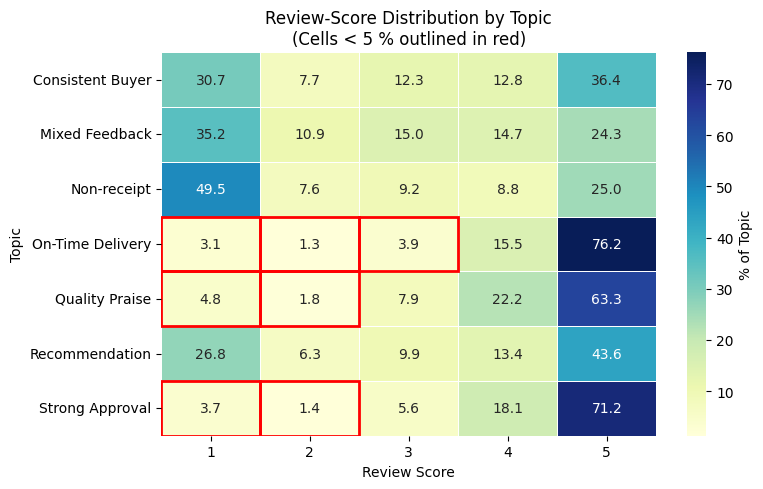

In [65]:
# Pivot to wide form
heat_df = report.pivot(
    index='Topic Name',
    columns='Review Score',
    values='Pct of Topic'
)

plt.figure(figsize=(8,5))
sns.heatmap(
    heat_df,
    annot=True, fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label':'% of Topic'},
    linewidths=0.5
)

# Highlighted anomalies by drawing a red box around any cell < 5%
for (i, topic) in enumerate(heat_df.index):
    for (j, score) in enumerate(heat_df.columns):
        if heat_df.loc[topic, score] < 5.0:
            plt.gca().add_patch(plt.Rectangle(
                (j, i), 1, 1, fill=False, edgecolor='red', lw=2
            ))

plt.title("Review‐Score Distribution by Topic\n(Cells < 5 % outlined in red)")
plt.xlabel("Review Score")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


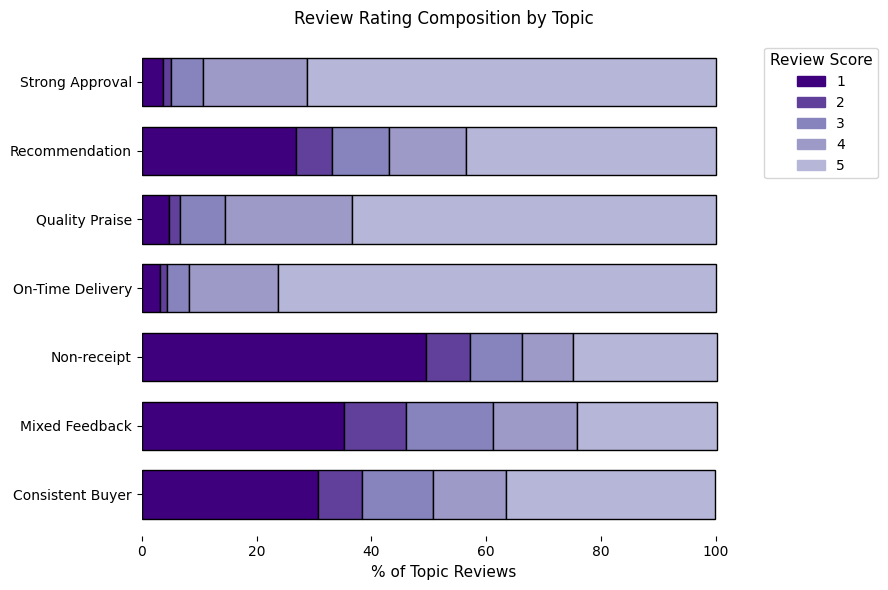

In [66]:
# Pivot to wide form: rows = topic names, cols = star ratings
stack_df = report.pivot(
    index='Topic Name',
    columns='Review Score',
    values='Pct of Topic'
).fillna(0)


cmap = plt.get_cmap("Purples")
colors = [cmap(1.0),  cmap(0.8), cmap(0.6), cmap(0.5), cmap(0.4)]

fig, ax = plt.subplots(figsize=(9, 6))
stack_df.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    width=0.7,
    legend=False
)

handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
labels = [str(s) for s in stack_df.columns]
ax.legend(
    handles, labels,
    title="Review Score",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    fontsize=10,
    title_fontsize=11
)

ax.set_xlabel("% of Topic Reviews", fontsize=11, color='black')
ax.set_ylabel("")
ax.set_title("Review Rating Composition by Topic", fontsize=12, pad=12)

sns.despine(left=True, bottom=True)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()